## Project #2 - No Show Appointments

## Questions we want to answer in the end

### General question
1. which characteristics determine that a patient will not appear?

### Intermediate questions
2. Do the patients' age or gender influence their no-show?
3. Patients residing in certain places are more likely to no-show?
4. Are there days of the week of scheduled appointments that are most likely to no-show patients?
5. Has the age of the patients influenced their no-show?
6. Patients with any disease are more likely not to show up?
7. Does the patient's scholarship receipt influence his absence?
8. Are there commom no-show patients (Patients that don't show up frequently?)



### 1. Data exploration in order to find dispensable columns and missing data

In [1]:
# Importing Modules
import pandas as pd
import matplotlib.pyplot as plt

# Importing data
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv')

# Ensuring that all columns will be lowercase
df.rename(columns=lambda x: x.lower(), inplace=True)

# Getting some data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [2]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


After *info()*, it is possible to know the number of samples (110527) and features (14) as well each feature data type

In [3]:
# Checking the number of unique values
df.nunique()

patientid          62299
appointmentid     110527
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no-show                2
dtype: int64

### 2. Data cleaning and transformation
As appointmentid feature is exclusive to each record (same number of entries and total samples), it can be droped. At a first glance, it seems that patientid could be removed once is a very specific value, but in a furder analysis it is possible to see that the number of unique values in patient id is less the total samples. It indicates that there are patients with more than one appointment. Hence, It is possible to identify those patients that have more no show appointments.

In [4]:
# Removing appointmentid
df.drop(['appointmentid'], axis=1, inplace=True)
df.nunique()

patientid          62299
gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no-show                2
dtype: int64

In [5]:
# Checking whether there are inconsistent data like:
# age < 0
df.drop(df.query('age < 0').index, inplace=True)
# appointmentday before scheduledday
df.drop(df.query('appointmentday < scheduledday').index, inplace=True)

If there are duplicates, they can be removed

In [6]:
# Checking duplicates
df.duplicated().sum()
# Droping duplicates
df.drop_duplicates(inplace=True)

Checking if there are null values

In [7]:
# Checking if there are null values
df.isnull().sum()

patientid         0
gender            0
scheduledday      0
appointmentday    0
age               0
neighbourhood     0
scholarship       0
hipertension      0
diabetes          0
alcoholism        0
handcap           0
sms_received      0
no-show           0
dtype: int64

It was decided to create two columns to keep the weekday of schedule and appointment respectively. It was considered important to check if some specifics weekdays have more no show occurrencies. 

Besides, It was decided to create other two columns to check if the schedule and appointment were made in the beginning (days between 1 and 10), middle (days between 11 and 20) or in the end of the month (days between 21 and 31). That was decided in order to check if there is any correlation between the period of the month and the amount of no shows.

In order to create those four columns, two functions were created. The first one *getMonthPeriodFromDate* [i] receives the date value as a string, once 'scheduledday' and 'appointmentday' has string values in original dataset, [ii] converts date value to DateTime and gets the day value. After that [iii] returns the period (beginning, middle or end).

The second function *getWeekDayFromDate()* receives the weekday as number end returns it as a string ('Monday' to 'Sunday')

Both functions were used to all items from 'scheduledday' and 'appointmentday' with 'map'. It was noticied that map function has a bad performance. Maybe there are alternatives to obtain the same result.

In [8]:
# Function that returns if a data is from beginning (1-10), middle (11-20) or end (20-31) of the month
def getMonthPeriodFromDate(dateAsStr):
    if pd.to_datetime(dateAsStr).day <= 10:
        return "beginning"
    elif pd.to_datetime(dateAsStr).day > 10 and pd.to_datetime(dateAsStr).day <= 20:
        return "middle"
    else:
        return "end"

In [9]:
# Function that returns the name of weekday
def getWeekDayFromDate(dateAsStr):
    switcher = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switcher.get(pd.to_datetime(dateAsStr).weekday())

In [10]:
# Function that returns the name of the month
def getMonthFromDate(dateAsStr):
    switcher = {
        1: "January",
        2: "February",
        3: "March",
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August",
        9: "September",
        10: "October",
        11: "November",
        12: "December"
    }
    return switcher.get(pd.to_datetime(dateAsStr).month)

In [11]:
# Function that returns the Age Range from age
# The age range considered is:
#    Baby  -> [0,3]
#    Child -> [4, 12]
#    Teenager -> [13, 19]
#    Adult -> [20, 60]
#    Old -> [61, ...]
def getAgeRange(age):
    if age >= 0 and age <= 3:
        return 'Baby'
    elif age >= 4 and age <=12:
        return 'Child'
    elif age >= 13 and age <= 19:
        return 'Teenager'
    elif age >= 20 and age <= 60:
        return 'Adult'
    else:
        return 'Old'

In [12]:
# Creating four new columns (two to get weekday and periodo of the month to scheduled day and two to appointment day)
# Each element of columns 'scheduledday' and 'appointmentday' is passed to the functions getMonthPeriodFromDate and getWeekDayFromDate by map 
# bad performance here :(
df['age_range'] = df['age'].map(getAgeRange)

df['scheduled_weekday'] = df['scheduledday'].map(getWeekDayFromDate)
df['schedule_period_of_month'] = df['scheduledday'].map(getMonthPeriodFromDate)
df['schedule_month'] = df['scheduledday'].map(getMonthFromDate)

#df['appointment_weekday']     = pd.to_datetime(df['appointmentday']).dt.weekday.map(getWeekDayFromDate)
df['appointment_weekday']     = df['appointmentday'].map(getWeekDayFromDate)
df['appointment_period_of_month'] = df['appointmentday'].map(getMonthPeriodFromDate)
df['appointment_month'] = df['appointmentday'].map(getMonthFromDate)

df.head()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_range,scheduled_weekday,schedule_period_of_month,schedule_month,appointment_weekday,appointment_period_of_month,appointment_month
5,9.598513e+13,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No,Old,Wednesday,end,April,Friday,end,April
6,7.336882e+14,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,April,Friday,end,April
7,3.449833e+12,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,Wednesday,end,April,Friday,end,April
9,7.812456e+13,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No,Teenager,Wednesday,end,April,Friday,end,April
10,7.345362e+14,F,2016-04-27T14:58:11Z,2016-04-29T00:00:00Z,30,NOVA PALESTINA,0,0,0,0,0,0,No,Adult,Wednesday,end,April,Friday,end,April


In [13]:
df['days_between_sched_appoint'] = pd.to_datetime(df['appointmentday']) - pd.to_datetime(df['scheduledday'])
df.tail()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,...,sms_received,no-show,age_range,scheduled_weekday,schedule_period_of_month,schedule_month,appointment_weekday,appointment_period_of_month,appointment_month,days_between_sched_appoint
110522,2.572134e+12,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,...,1,No,Adult,Tuesday,beginning,May,Tuesday,beginning,June,34 days 14:44:25
110523,3.596266e+12,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,...,1,No,Adult,Tuesday,beginning,May,Tuesday,beginning,June,34 days 16:32:27
110524,1.557663e+13,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,...,1,No,Adult,Wednesday,end,April,Tuesday,beginning,June,40 days 07:56:08
110525,9.213493e+13,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,...,1,No,Adult,Wednesday,end,April,Tuesday,beginning,June,40 days 08:50:37
110526,3.775115e+14,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,...,1,No,Adult,Wednesday,end,April,Tuesday,beginning,June,40 days 10:29:04


## 3. Exploring with visuals to answer some questions

Answering the questions

2. Do the patients' age or gender influence their no-show?

 * In order to answer the question 1, let's check the data behavior about gender and age against no-shows

In [14]:
df.groupby(['gender', 'no-show']).size()

gender  no-show
F       No         34160
        Yes        13544
M       No         16932
        Yes         6773
dtype: int64

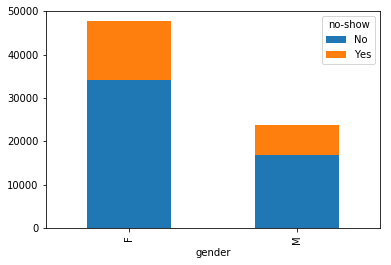

In [15]:
df.groupby(['gender', 'no-show']).size().unstack().plot(kind='bar',stacked=True);

In [16]:
df.groupby(['age_range', 'no-show']).size()

age_range  no-show
Adult      No         28099
           Yes        11671
Baby       No          3269
           Yes         1458
Child      No          5215
           Yes         2338
Old        No         10966
           Yes         2805
Teenager   No          3543
           Yes         2045
dtype: int64

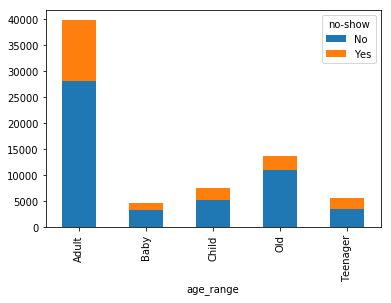

In [17]:
df.groupby(['age_range', 'no-show']).size().unstack().plot(kind='bar',stacked=True);

* According to the graphs and data, the gender can not determine a tendency to no-show once both 'F' and 'M' have a very close no-show frequency (About 28%)]

* According to the graphs and data, the age range Teenager has about 37% of no-show frequency. Baby and Child have about 30%. Those three types could be considered more likely not to show up.

In the next question we check if the place where patients are have influence in the no-show

3. Patients residing in certain neighbourhood are more likely to no-show?

In [30]:
df['neighbourhood'].value_counts()

JARDIM CAMBURI                 5130
MARIA ORTIZ                    3729
RESISTÊNCIA                    2775
JARDIM DA PENHA                2654
ITARARÉ                        2341
CENTRO                         2248
TABUAZEIRO                     1917
JESUS DE NAZARETH              1754
BONFIM                         1697
JABOUR                         1680
CARATOÍRA                      1667
SANTA MARTHA                   1623
SANTO ANTÔNIO                  1610
SANTO ANDRÉ                    1605
SÃO PEDRO                      1572
ILHA DO PRÍNCIPE               1503
ANDORINHAS                     1461
ROMÃO                          1404
SÃO JOSÉ                       1369
DA PENHA                       1354
MARUÍPE                        1348
ILHA DE SANTA MARIA            1284
FORTE SÃO JOÃO                 1271
SÃO CRISTÓVÃO                  1269
NOVA PALESTINA                 1185
BELA VISTA                     1102
GURIGICA                       1101
CRUZAMENTO                  

The next question tries to infer if there is any correlation between the week days of schedule and appointments. Maybe because there are some influence factors that no-show might be increased in some week days.
4. Are there days of the week of scheduled appointments that are most likely to no-show patients?

In [24]:
df.groupby(['scheduled_weekday', 'no-show']).size()

scheduled_weekday  no-show
Friday             No          8839
                   Yes         3474
Monday             No         10598
                   Yes         4229
Saturday           No            14
                   Yes            1
Thursday           No          8633
                   Yes         3405
Tuesday            No         12057
                   Yes         4832
Wednesday          No         10951
                   Yes         4376
dtype: int64

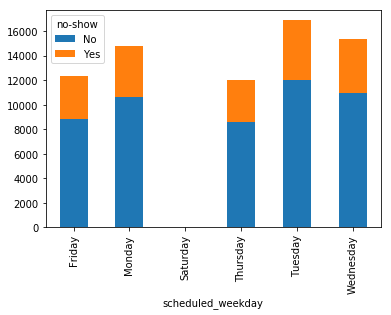

In [26]:
df.groupby(['scheduled_weekday', 'no-show']).size().unstack().plot(kind='bar',stacked=True);

In [27]:
df.groupby(['appointment_weekday', 'no-show']).size()

appointment_weekday  no-show
Friday               No          8746
                     Yes         3631
Monday               No         10097
                     Yes         4351
Saturday             No            22
                     Yes            9
Thursday             No          8201
                     Yes         3063
Tuesday              No         11679
                     Yes         4672
Wednesday            No         12347
                     Yes         4591
dtype: int64

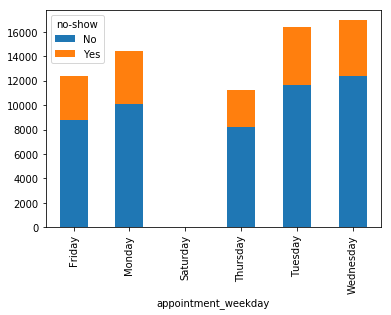

In [255]:
df.groupby(['appointment_weekday', 'no-show']).size().unstack().plot(kind='bar',stacked=True);

As we can see in both previous graphs there is no correlation between week day in which the schedule was made or the appointment was made. The proportion of no-show is almost the same among all week days (29%).